# Packages

In [1]:
from quocslib.optimalcontrolproblems.OneQubitProblem_2fields import OneQubit2Fields
import time, datetime

import scipy
import numpy as np
from scipy import linalg, interpolate
from scipy.ndimage import gaussian_filter1d
import os
import sys
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import time
import copy as cp
from scipy import signal
# import necessary stuff from quidi
from logic.pulsed.pulse_objects import PulseBlock, PulseBlockEnsemble, PulseSequence
from user_scripts.Timo.own.optimalcontrol.oc_simlib import TimeDependentSimulation, SimParameters, ArbPulse, PredefinedArbPulses

import logging
logging.basicConfig(filename='logfile.log', filemode='w', level=logging.DEBUG)
logger = logging.getLogger(__name__)

0

0

In [2]:
pulsedmeasurementlogic.pulsegenerator().get_sample_rate()

25000000000.0

# Library functions

In [3]:

def list_2_csv(in_list):
    str_list = ""
    
    if type(in_list) != list:
        in_list = [in_list]
        
    for el in in_list:
        str_list += f"{el}, "
    
    if len(str_list) > 0:
        str_list = str_list[:-2]
        
    return str_list

def dict_2_header_str(in_dict):
    out_str = ""
    for key, val in in_dict.items():
        out_str += f"{key}: {val}\n"
        
    return out_str

def get_pulse_filename(path, name="", name_ampl="amplitude.txt", name_phase="phase.txt"):
    return os.path.abspath(path + "/" + name + name_ampl), os.path.abspath(path + "/" + name + name_phase)

def save_pulse(path, data_ampl, data_phase, name="", name_ampl="amplitude.txt", name_phase="phase.txt"):
    header_dict = {}
    try:
        now = datetime.datetime.now() # current date and time
        header_dict['timestamp'] = now.strftime("%Y/%m/%d-%H:%M:%S")
        header_dict['script_parameters'] = script_params
        header_dict.update(opti_comm_dict['optimization_dictionary'])
        
        fname_ampl, fname_phase = get_pulse_filename(path, name=name, name_ampl=name_ampl, name_phase=name_phase)
        
        if data_ampl is not None:
            try:
                os.remove(fname_ampl)
            except IOError:
                pass
            np.savetxt(fname_ampl,  data_ampl,  header=dict_2_header_str(header_dict))
        if data_phase is not None:
            try:
                os.remove(fname_phase)
            except IOError:
                pass
            np.savetxt(fname_phase, data_phase, header=dict_2_header_str(header_dict))
    except:
        logger.exception("")

        
def save_optimization_result(path, name="opt_res_", name_ampl="amplitude.txt", name_phase="phase.txt"):
    try:
        # save fom by same function as pulse
        save_pulse(path, fom_all, None, name=name, name_ampl='fom.txt', name_phase='')
        
        # save best pulse
        pulse = get_pulse_from_logic(get_best=True)
        t_amplitude = pulse.get_timegrid(unit='s')
        t_phase = pulse.get_timegrid(unit='s')
        amplitude = pulse.get_data_ampl(unit='V')
        phase = pulse.get_data_phase(unit='V')
        
        data_ampl = np.column_stack((t_amplitude, amplitude))
        data_phase = np.column_stack((t_phase, phase))

        save_pulse(path, data_ampl, data_phase, name=name, name_ampl=name_ampl, name_phase=name_phase)

    except:
        logger.exception("")

def interpolate_2_timegrid(pulse, timegrid_new, timegrid_unit='s'):
    amplitude_func = scipy.interpolate.interp1d(pulse.timegrid, pulse.get_data_ampl(unit=pulse.data_unit),
                                                fill_value=0, bounds_error=False)
    phase_func = scipy.interpolate.interp1d(pulse.timegrid, pulse.get_data_phase(unit=pulse.data_unit),
                                            fill_value=0, bounds_error=False)
    
    pulse_new = cp.deepcopy(pulse)
    if timegrid_unit != pulse.timegrid_unit:
        raise NotImplemented # may rescale the old pulse first
    if timegrid_new[-1] < pulse.timegrid[-1]:
        # this would work, but probably not intended
        raise ValueError("Too short new timegrid would cut pulse.")
    
    pulse_new._data_ampl = amplitude_func(timegrid_new - timegrid_new[0])
    pulse_new._data_phase = phase_func(timegrid_new - timegrid_new[0])
    pulse_new._timegrid_ampl = timegrid_new
    pulse_new._timegrid_phase = timegrid_new
    
    # invalidate old data fields
    pulse_new._folder = None
    pulse_new._file = None
    pulse_new._file_ampl = None
    pulse_new._file_phase = None
    
    return pulse_new

def scale_power(pulse, factor=1):    
    pulse_new = cp.deepcopy(pulse)
    
    pulse_new._data_ampl = factor*pulse_new._data_ampl
    pulse_new._data_phase = factor*pulse_new._data_phase
    pulse_new._timegrid_ampl = 1/factor*pulse_new._timegrid_ampl
    pulse_new._timegrid_phase = 1/factor*pulse_new._timegrid_phase
    
    # invalidate old data fields
    pulse_new._folder = None
    pulse_new._file = None
    pulse_new._file_ampl = None
    pulse_new._file_phase = None
    
    return pulse_new
    
        

def _get_sine_func(time_array, amplitude_func, frequency, phase_rad, phase_func):
    samples_arr = amplitude_func(time_array - time_array[0]) * np.sin(2*np.pi * frequency * time_array + phase_rad) \
                  + phase_func(time_array - time_array[0]) * np.cos(2*np.pi * frequency * time_array + phase_rad)

    return samples_arr

def sample_pulse(pulse, f_carrier, phase_carrier_rad=0):
    
    timegrid_pulse = pulse.get_timegrid(unit='s')
    t_pulse = timegrid_pulse[-1]
    
    dt_sample = 1/pulsedmeasurementlogic.pulsegenerator().get_sample_rate()
    timegrid_sampling = np.arange(0, t_pulse, dt_sample)
    amplitude = pulse.get_data_ampl(unit='V')
    phase = pulse.get_data_phase(unit='V')

    
    amplitude_func = interpolate.interp1d(timegrid_pulse, amplitude)
    phase_func = interpolate.interp1d(timegrid_pulse, phase)
    samples_arr = _get_sine_func(timegrid_sampling, amplitude_func, f_carrier, phase_carrier_rad, phase_func)
    
    return samples_arr

def get_rescale_factor_ampl(pulse, f_carrier, max_ampl_v=0.25):
    # shaddows qudi::sampling_func
    
    # sampling for the awg has an unknown pulse position and hence phase
    # make sure that the pulse works for all phases by calculating rescale factor for worst case
    phases_rad = np.linspace(0, 2*np.pi, 100)
    samples_arr = sample_pulse(pulse, f_carrier)
    for ph in phases_rad:
        samples_curr = sample_pulse(pulse, f_carrier, phase_carrier_rad=ph)
        if np.max(samples_curr) > np.max(samples_arr):
            samples_arr = samples_curr
            logger.debug(f"New max pulse ampl {np.max(samples_curr)} for phase {ph/np.pi} pi")
            
    max_sample_before = np.max(samples_arr)
    
    # avoid re-scaling by the pg, todo: think of better way
    import scipy
    if max(abs(samples_arr)) > 0.25:
        biggest_val = max([abs(np.min(samples_arr)), np.max(samples_arr)])
        mapper = scipy.interpolate.interp1d([-biggest_val, biggest_val], [-max_ampl_v, max_ampl_v])
        samples_arr = mapper(samples_arr)
        
    max_samples_after = np.max(samples_arr)
    
    return max_samples_after/max_sample_before
    
        
def get_pulse_from_logic(get_best=False):
    
    if get_best:
        optimizer_obj = optimizationlogic.optimization_obj
        best_dict = optimizer_obj.opt_alg_obj.get_best_controls()

        pulses, timegrids, parameters = best_dict['pulses'], best_dict['timegrids'], best_dict['parameters']
    else:
        pulses, parameters, timegrids = controlslogic.pulses, controlslogic.parameters, controlslogic.timegrids
    
    # save pulse as raw from logic
    fname_tmp = '.tmp_pulse_'
    fname_tmp_ampl, fname_tmp_ph = get_pulse_filename(folder_path, name=fname_tmp)
    
    data_ampl = np.column_stack((timegrids[0], pulses[0]))
    data_phase = np.column_stack((timegrids[0], pulses[1]))
    save_pulse(folder_path, data_ampl, data_phase, name=fname_tmp)
    
    # reload as a pulse object
    pulse = ArbPulse.load_pulse(folder_path, fname_tmp, unit_t='s', unit_data='V')
    os.remove(fname_tmp_ampl)
    os.remove(fname_tmp_ph)
    
    fac = get_rescale_factor_ampl(pulse, f_res, max_ampl_v=ampl_max)
    if fac != 1:
        logger.warning(f"Rescaling pulses with fac={fac} prior to saving and sampling.")
    
    pulse._data_ampl  = fac*pulse._data_ampl
    pulse._data_phase = fac*pulse._data_phase
    
    return pulse

#get_pulse_from_logic(True)

# QuOCS and Qudi with Noise

## Creation of the optimization dictionary

The optimization dictionary contains all the settings compulsory for the optimization algorithm in order to run a proper optimization.

In [4]:
optimization_client_name = "test_dCRAB_Noisy_2_control_fields"

optimization_dictionary = {"optimization_client_name": optimization_client_name,
                           'opti_algorithm_module': 'quocslib.optimalalgorithms.dCRABNoisyAlgorithm', 
                           'opti_algorithm_class': 'DCrabNoisyAlgorithm', 
                          }

Number of iteration and super-iterations

In [5]:
# Total number of dCRAB superiteration
super_iteration_number = 10000000
# Maximum number of iteration per super-iteration (in max_eval_total: maximale anzahl von evaluation steps gesamt)
maximum_function_evaluations_number = 500

To activate the drift compensation and the re-evaluation steps add

In [6]:
optimization_dictionary['algorithm_settings'] = {"algorithm_name": "dCRAB",
                                                 "super_iteration_number": super_iteration_number,
                                                 #"max_eval_total": super_iteration_number * maximum_function_evaluations_number,
                                                 "FoM_goal": 0.00001,
                                                 "total_time_lim": 5*48*60,  # minutes
                                                 "compensate_drift": {
                                                     "compensate_after_SI": True,
                                                     "compensate_after_minutes": 2*15
                                                 },
                                                 "random_number_generator":{
                                                     "seed_number":420   # todo: really fix a seed here?
                                                 },
                                                 #"re_evaluation": {
                                                     #"re_evaluation_steps": [0.3, 0.5, 0.51]
                                                 #}
}
optimization_dictionary['algorithm_settings'] 

{'algorithm_name': 'dCRAB', 'super_iteration_number': 10000000, 'FoM_goal': 1e-05, 'total_time_lim': 14400, 'compensate_drift': {'compensate_after_SI': True, 'compensate_after_minutes': 30}, 'random_number_generator': {'seed_number': 420}}

Settings for the inner algorithm used by dCRAB

In [8]:
180/(script_params['runtime_per_epoch']/60)

30.0

In [10]:
optimization_dictionary['algorithm_settings']["dsm_settings"] = {'general_settings': {
                                                "dsm_algorithm_name": "NelderMead", 
                                                'is_adaptive': False
                                            }, 
                                            'stopping_criteria': {
                                                #"max_eval": 100,
                                                "time_lim": 120,  #min
                                                #"xatol": 1e-10, 
                                                #"frtol": 1e-10,
                                                "change_based_stop": {
                                                    "cbs_funct_evals": 500, 
                                                    "cbs_change": 0.01    # stop if slope below
                                                }
                                            }
}
optimization_dictionary['algorithm_settings']

{'algorithm_name': 'dCRAB', 'super_iteration_number': 10000000, 'FoM_goal': 1e-05, 'total_time_lim': 14400, 'compensate_drift': {'compensate_after_SI': True, 'compensate_after_minutes': 30}, 'random_number_generator': {'seed_number': 420}, 'dsm_settings': {'general_settings': {'dsm_algorithm_name': 'NelderMead', 'is_adaptive': False}, 'stopping_criteria': {'time_lim': 540, 'change_based_stop': {'cbs_funct_evals': 500, 'cbs_change': 0.01}}}}

### Times

In [78]:
t_rabi_rect = 78.2e-9  
pix_pulse = 1
t_oc_pulse = 112.0e-9 #1.0000000000000001e-07
n_timebins = 1000
#t_oc_pulse = timegrid_ampl[-1]
fac_oc_guess = 1.0 # make initial guess not too good, otherwise hard for optimizer

ampl_max = 0.25  # V
ampl_rect = 0.25  # V 


fac_oc_rect = t_oc_pulse/(0.5*t_rabi_rect/pix_pulse)
if fac_oc_rect  < 3:
    logger.warning(f"OC pulse should be >3x as long as rect, now: {t_oc_pulse/(0.5*t_rabi_rect/pix_pulse)}")

time_p = {'time_name': 'time_p', 'initial_value': t_oc_pulse} # pulse length
optimization_dictionary['times'] = [time_p]
ampl_oc_guess = fac_oc_guess*1/fac_oc_rect*ampl_rect

ampl_oc_guess, fac_oc_rect
t_oc_pulse, n_timebins

(1.12e-07, 1000)

### Parameters

In [79]:
optimization_dictionary['parameters'] = []

In [80]:
optimization_dictionary['times']

[{'time_name': 'time_p', 'initial_value': 1.12e-07}]

### Pulses

#### Generate from predefined function

Levitt composite pulse

In [100]:
pulse = PredefinedArbPulses.generate_levitt(20e6, n_t=1000)
pulse._func_omega_mhz_2_ampl_v = lambda x: x/20*0.25

from scipy.ndimage import gaussian_filter1d
pulse._data_ampl = gaussian_filter1d(pulse._data_ampl, 5)
pulse._data_phase = gaussian_filter1d(pulse._data_phase, 5)

#pulse.as_dict()

Rect pulse

In [164]:
def generate_rect_pi(omega, phase=0, n_t=1000, t_pulse=None):
    """
    Generate a levitt pulse as a optimal control pulse file.
    Assumes that quadratues I*sin(f_mw*t) + Q*cos(f_mw*t) are used in sampling.
    @param t_pulse: if None, auto length of pulse. Else zero pad to specified length.
    """

    omega_mhz = omega * 1e-6

    get_t_pix = PredefinedArbPulses.get_t_pix
    get_iq = PredefinedArbPulses.get_iq

    tpi_us = get_t_pix(omega_mhz, pix=1)

    if not t_pulse:
        t_pulse = tpi_us
    else: 
        t_pulse = 1e6*t_pulse

    # rabi in MHz, times in us
    timegrid_us = np.linspace(0, t_pulse, n_t)
    data_ampl = np.zeros((len(timegrid_us)))  # I quadrature
    data_phase = np.zeros((len(timegrid_us)))  # Q

    phases = [0 + phase]
    tpulse_by_pi = [1]
    # pad with zero amplitude/phase
    if t_pulse != tpi_us:
        phases.append(0)
        tpulse_by_pi.append(0)
    # phases = [np.pi/2]
    # tpulse_by_pi = [0.5]

    t_curr_us, t_end_us = 0, 0
    for i_comppulse, phi in enumerate(phases):
        pix = tpulse_by_pi[i_comppulse]
        if pix != 0:
            t_end_us = t_curr_us + get_t_pix(omega_mhz, pix=pix)
            val_iq = np.asarray(get_iq(phi)) * omega_mhz
        else:  # zero pad until end
            t_end_us = timegrid_us[-1]
            val_iq = np.asarray([0, 0])

        idx_start = np.argmin(np.abs(timegrid_us - t_curr_us))
        idx_end = np.argmin(np.abs(timegrid_us - t_end_us))


        data_ampl[idx_start:idx_end + 1] = val_iq[0]
        data_phase[idx_start:idx_end + 1] = val_iq[1]

        if t_curr_us == timegrid_us[-1]:
            break
        t_curr_us = t_end_us

    idx_end = np.argmin(np.abs(timegrid_us - t_end_us))

    assert idx_end == n_t - 1

    pulse = ArbPulse()
    pulse.name = 'rect_phi={phase/np.pi:.1f}pi'

    pulse.timegrid_unit = 'us'
    pulse.data_unit = 'MHz'

    pulse._data_ampl = data_ampl
    pulse._data_phase = data_phase
    pulse._timegrid_ampl = timegrid_us
    pulse._timegrid_phase = timegrid_us

    return pulse

PredefinedArbPulses.generate_rect_pi = generate_rect_pi    

In [190]:
t_oc_pulse

1e-07

In [188]:
np.linspace(0,t_oc_pulse,10)[-5:]*1e6

array([0.05555556, 0.06666667, 0.07777778, 0.08888889, 0.1       ])

In [172]:
1e3*np.linspace(0,t_oc_pulse)[-1]

9.999999999999999e-05

In [200]:
# pi pulse with fixed lentgh
pulse = PredefinedArbPulses.generate_rect_pi(20e6, n_t=n_timebins, t_pulse=t_oc_pulse)
# hard pi pulse with auto lentgh
#pulse = PredefinedArbPulses.generate_rect_pi(20e6, n_t=1000)
pulse._func_omega_mhz_2_ampl_v = lambda x: x/20*0.25

fname = 'dummy' # to make loadable below

pulse.as_dict()
#pulse._timegrid_phase[-1]


{'name': 'rect_phi={phase/np.pi:.1f}pi', 'folder': None, 'file': [], 'timegrid_unit': 'us', 'data_unit': 'MHz', 'data_ampl': array([20., 20., 20., ...,  0.,  0.,  0.]), 'data_phase': array([0., 0., 0., ..., 0., 0., 0.]), 'timegrid_ampl': array([0.00000000e+00, 5.00250125e-05, 1.00050025e-04, ...,
       9.98999500e-02, 9.99499750e-02, 1.00000000e-01]), 'timegrid_phase': array([0.00000000e+00, 5.00250125e-05, 1.00050025e-04, ...,
       9.98999500e-02, 9.99499750e-02, 1.00000000e-01])}

#### Load initial guess from extern
... or with fname=None assume slow rect pulse.

In [81]:
#folder = r"C:\Software\qudi_data\optimal_control_assets"
folder = r"C:\Software\qudi_data\optimal_control_assets\20220725_2_lessClipping"
folder = r"C:\Software\qudi_data\optimal_control_assets\20220726_1_NV1_penalty_fac=1"

#fname =  r"on_nv=2_"
fname = r"opt_res_"

# load pulse defined in MHz domain
folder = r"C:\Software\qudi_data\optimal_control_assets\Reisser_MSc_pulse_1"
fname = r"Opt_Pulse_01_"
# ONLY for loading Reisser pulse
pulse = ArbPulse.load_pulse(folder, fname, unit_t='ns', unit_data='MHz',
                            func_ampl_v_2_omega_mhz=lambda x: x/0.25*13.2,
                            func_omega_mhz_2_ampl_v=lambda y: y/13.849* 0.25 * 13.849/13.2)
pulse.set_unit_time('s')
# rescale 20 -> 13.2 MHz
#pulse._data_ampl  = 76.4/49.3*pulse._data_ampl
#pulse._data_phase = 76.4/49.3*pulse._data_phase
pulse = scale_power(pulse, factor=0.9)
pulse._func_ampl_v_2_omega_mhz = lambda x: x/0.25*13.2
pulse._func_omega_mhz_2_ampl_v = lambda y: y/13.849* 0.25 * 13.849/13.2


folder = r"C:\Software\qudi_data\optimal_control_assets\20220831_3_nv2_rabiMax=15MHz_guessFromReisser_110ns_pen=10"
name = "opt_res_"
#name = "opt_res_"
pulse = ArbPulse.load_pulse(folder, name, unit_t='s', unit_data='V',
                            func_ampl_v_2_omega_mhz=lambda x: x/0.25*(1e-6/78.2e-9),
                            )


# load pulses in V domain (for AWG)
#folder = r"C:\Software\qudi_data\optimal_control_assets\20220726_1_NV1_penalty_fac=1"
#folder = r"C:\Software\qudi_data\optimal_control_assets\Reisser_MSc_pulse_1"
#folder =  r"C:\Software\qudi_data\optimal_control_assets\20220727_1_guessFromReisserMsc"
#folder = r"C:\Software\qudi_data\optimal_control_assets\20220824_1_nv1_onEq_guessFromReisser_pen=10"
#folder = r"C:\Software\qudi_data\optimal_control_assets\20220830_4_nv2_rabiMax=15MHz_guessFromReisser_SimOnly_pen=0"
#fname =  r"on_nv=2_"
#fname = r"opt_res_"
#fname = r"Opt_Pulse_01_"




#pulse = ArbPulse.load_pulse(folder, fname, unit_t='s', unit_data='V')

#pulse = ArbPulse.load_pulse(folder, fname, unit_t='s', unit_data='V')

# rescale amplitude if needed
# NOW rabi/ BACK rabi
#pulse._data_ampl  = 76.4/49.3*pulse._data_ampl
#pulse._data_phase = 76.4/49.3*pulse._data_phase



np.max(pulse._data_ampl), np.max(pulse._data_phase), pulse.as_dict()

(0.24515081765787783, 0.0959055747742425, {'name': 'opt_res_', 'folder': 'C:\\Software\\qudi_data\\optimal_control_assets\\20220831_3_nv2_rabiMax=15MHz_guessFromReisser_110ns_pen=10', 'file': ['C:\\Software\\qudi_data\\optimal_control_assets\\20220831_3_nv2_rabiMax=15MHz_guessFromReisser_110ns_pen=10\\opt_res_amplitude.txt', 'C:\\Software\\qudi_data\\optimal_control_assets\\20220831_3_nv2_rabiMax=15MHz_guessFromReisser_110ns_pen=10\\opt_res_phase.txt'], 'timegrid_unit': 's', 'data_unit': 'V', 'data_ampl': array([ 0.13508877,  0.13473018,  0.13429677,  0.13379269,  0.1332234 ,
        0.1325951 ,  0.13191422,  0.13118689,  0.13041862,  0.12961406,
        0.12877691,  0.12790994,  0.12701514,  0.1260938 ,  0.12514674,
        0.12417439,  0.12317692,  0.12215432,  0.12110651,  0.1200333 ,
        0.11893449,  0.11780984,  0.11665911,  0.11548205,  0.11427841,
        0.11304793,  0.11179039,  0.11050556,  0.10919324,  0.10785324,
        0.10648539,  0.10508957,  0.10366565,  0.10221356

In [51]:
pulse.data_ampl
folder, fname, len(pulse.timegrid)

('C:\\Software\\qudi_data\\optimal_control_assets\\20220831_2_nv2_rabiMax=15MHz_guessFromReisser_110ns_pen=10', 'Opt_Pulse_01_', 1000)

### Set initial guess

In [82]:
#fname=None
gauss_filter_n = 0

len_oc_pulse = optimization_dictionary['times'][0]['initial_value']
timegrid = np.linspace(0, len_oc_pulse, n_timebins)
        

if fname:
    try:        
        pulse = pulse
        pulse = interpolate_2_timegrid(pulse, timegrid)
        
        if gauss_filter_n != 0:
            pulse._data_ampl = gaussian_filter1d(pulse._data_ampl, gauss_filter_n)
            pulse._data_phase = gaussian_filter1d(pulse._data_phase, gauss_filter_n)

        timegrid_ampl = pulse.get_timegrid(unit='s')
        
        if n_timebins != len(timegrid_ampl) or not np.isclose(len_oc_pulse,timegrid_ampl[-1]):
            raise RuntimeError(f"Timegrid of loaded init pulse ({timegrid_ampl[-1]}@{len(timegrid_ampl)})"
                                f"doesn't match settings ({len_oc_pulse}@{n_timebins}) after interpolation" 
                                f"Unexpected!")
    except:
        logger.exception("")
        fname = None
if fname:
    try:
        initial_guess_ampl = {'function_type': 'list_function', 'list_function': pulse.get_data_ampl(unit='V')}
        initial_guess_phase = {'function_type': 'list_function', 'list_function': pulse.get_data_phase(unit='V')}
    except:
        logger.exception("")
    # ATTENTION: ONLY FOR DEBUG
    #initial_guess_ampl = {'function_type': 'list_function', 'list_function': 1/1.4*pulse['data_ampl']}
    #initial_guess_phase = {'function_type': 'list_function', 'list_function': 1/1.4*pulse['data_phase']}
else:
    pulse = ArbPulse()
    pulse._timegrid_ampl = timegrid
    pulse._timegrid_phase = timegrid
    pulse._data_ampl = np.ones(timegrid.size)*ampl_oc_guess
    pulse._data_phase = np.ones(timegrid.size)*0
    pulse.timegrid_unit = 's'
    pulse.data_unit = 'V'
    
    initial_guess_ampl = {'function_type': 'lambda_function', 'lambda_function': f'lambda t: {ampl_oc_guess} + 0.0*t'}
    initial_guess_phase = {'function_type': 'lambda_function', 'lambda_function': f'lambda t: {0} + 0.0*t'}
    
initial_guess_ampl['function_type']

'list_function'

In [83]:
try:
    pulse.get_data_ampl(unit='V')
except:
    logger.exception("")

In [84]:
np.max(pulse.get_data_ampl(unit='V')), len(pulse.timegrid)

(0.24515081765787783, 1000)

In [85]:
vec_number = 3   #2-3
upper_freq_lim = 12  #8-12


    
pulse_amplitude = {'pulse_name': 'Amplitude', 
                           'upper_limit':ampl_max, 
                           'lower_limit': -ampl_max, 
                           'bins_number': n_timebins, 
                           'time_name': 'time_p', 
                           'amplitude_variation': 0.5*ampl_oc_guess, # added to guess amp, to create 3 points for start simplex
                           'basis': {'basis_name': 'Fourier', 
                                     'basis_class': 'Fourier', 
                                     'basis_module': 'quocslib.pulses.basis.Fourier', 
                                     'basis_vector_number': vec_number, # number of frequencies within the below defined range
                                     'random_super_parameter_distribution': 
                                     {'distribution_name': 'Uniform', 'distribution_class': 'Uniform', 
                                           'distribution_module': 'quocslib.pulses.superparameter.Uniform', 
                                           'lower_limit': 0.0, 'upper_limit': upper_freq_lim} # number of oscillations within pulse
                                    }, 
                           'scaling_function': {'function_type': 'lambda_function', 'lambda_function': 'lambda t: 1.0 + 0.0*t'}, 
                           'initial_guess': initial_guess_ampl,
                           'shrink_ampl_lim': True
                          }

pulse_phase = {'pulse_name': 'Phase', 
               'upper_limit': ampl_max, 
               'lower_limit': -ampl_max, 
               'bins_number': n_timebins, 
               'time_name': 'time_p', 
               'amplitude_variation': 0.5*ampl_oc_guess, # added to guess amp, to create 3 points for start simplex
               'basis': {'basis_name': 'Fourier', 
                         'basis_class': 'Fourier', 
                         'basis_module': 'quocslib.pulses.basis.Fourier', 
                         'basis_vector_number': vec_number, # number of frequencies within the below defined range
                         'random_super_parameter_distribution': 
                         {'distribution_name': 'Uniform', 'distribution_class': 'Uniform', 
                               'distribution_module': 'quocslib.pulses.superparameter.Uniform', 
                               'lower_limit': 0.0, 'upper_limit': upper_freq_lim} # number of oscillations within pulse
                        }, 
               'scaling_function': {'function_type': 'lambda_function', 'lambda_function': 'lambda t: 1.0 + 0.0*t'}, 
               'initial_guess': initial_guess_phase,
               'shrink_ampl_lim': True
              }

optimization_dictionary['pulses'] = [pulse_amplitude, pulse_phase]

ampl_oc_guess

0.08727678571428571

#### Plot Init guess

In [38]:
pulse._convert_si

<bound method ArbPulse._convert_si of <user_scripts.Timo.own.optimalcontrol.oc_simlib.ArbPulse object at 0x000000FF13549908>>

(0.24515081765787783, 12.539683767666384)

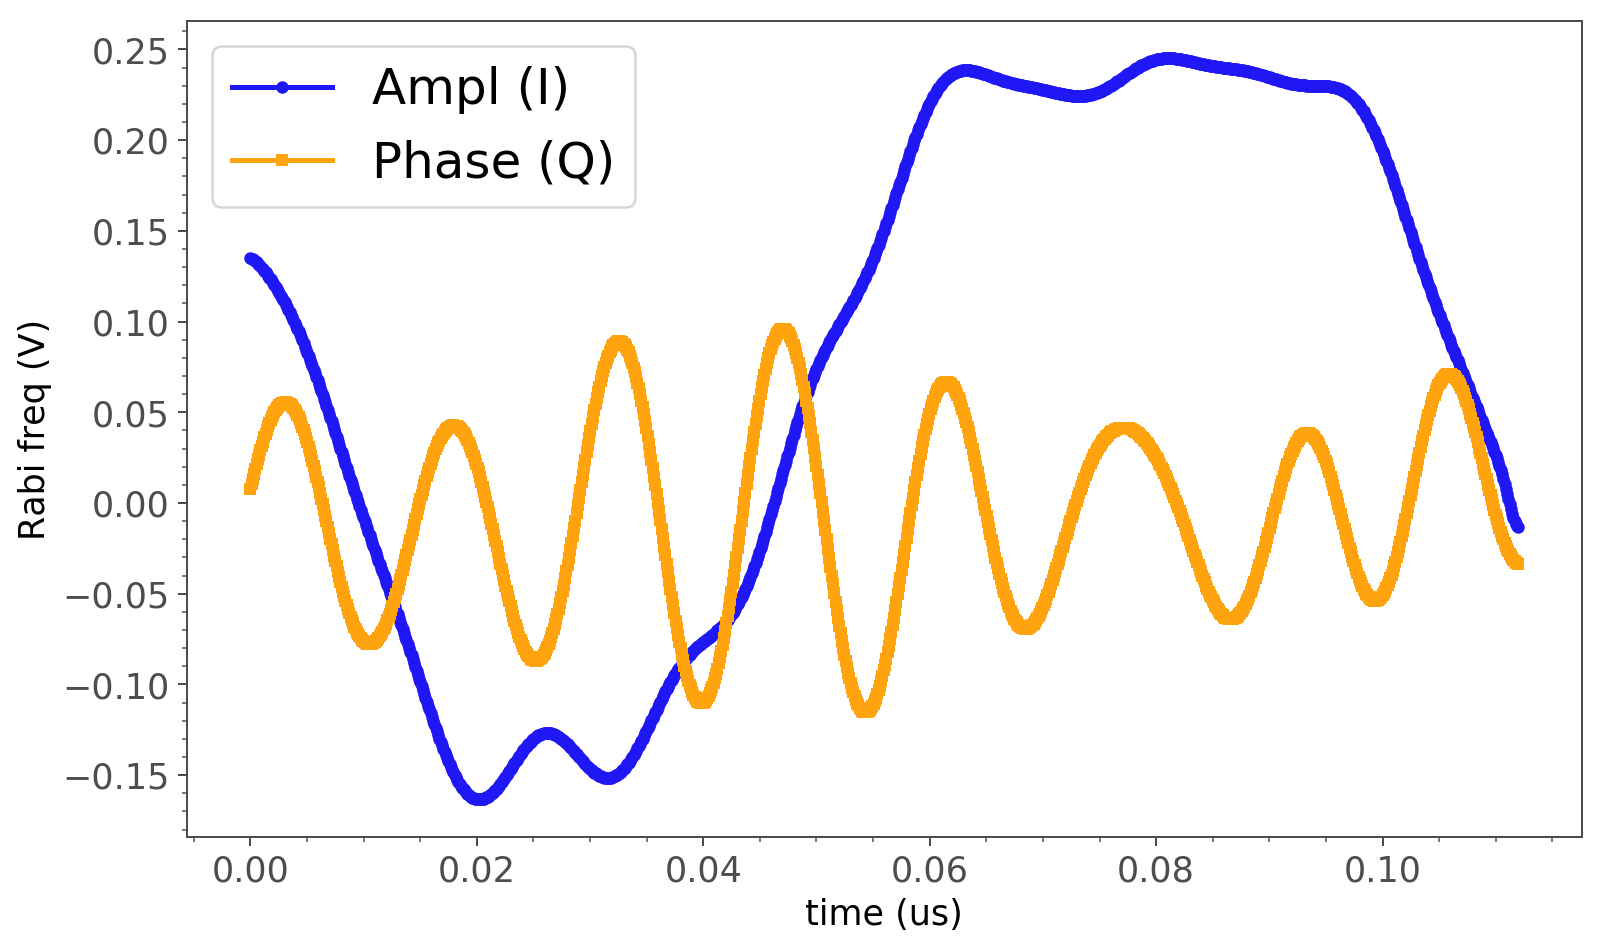

In [86]:
import matplotlib.pyplot as plt
    
t_amplitude = pulse.get_timegrid(unit='us')
amplitude = pulse.get_data_ampl(unit='V')
t_phase = pulse.get_timegrid(unit='us')
phase = pulse.get_data_phase(unit='V')

max_rabi = np.max([np.max(pulse.get_data_phase(unit='MHz')), np.max(pulse.get_data_ampl(unit='MHz'))])
max_ampl = np.max([np.max(phase), np.max(amplitude)])

try:
    plt.figure(figsize=(10,6))
    plt.plot(t_amplitude, amplitude, label="Ampl (I)")
    plt.plot(t_phase, phase, label="Phase (Q)")
   # plt.plot(t_phase, phase+amplitude, label="
    plt.ylabel("Rabi freq (V)")
    plt.xlabel("time (us)")
    plt.legend(loc='best', prop={'size': 20})
    plt.show()
except:
    logger.exception("")
    
max_ampl, max_rabi

Plot samples pulse and check whether amplitude rescaling is needed.

(0.24780878868741027, 1.0)

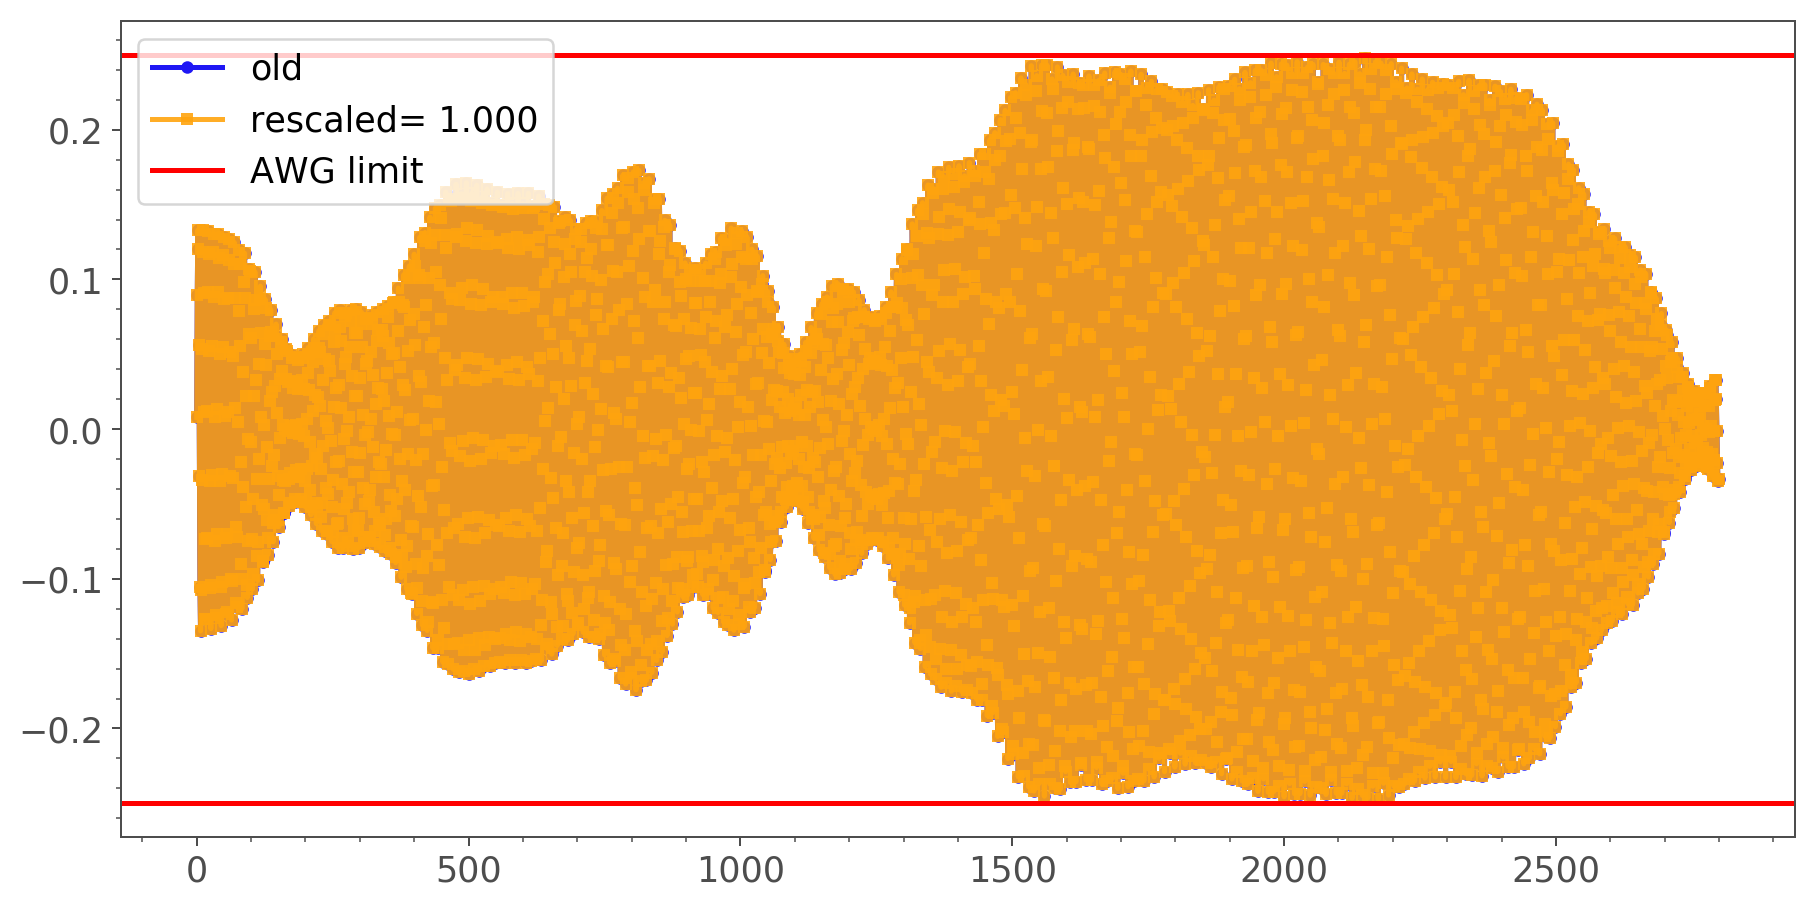

In [87]:
max_old = np.max(sample_pulse(pulse, f_res))

fac = get_rescale_factor_ampl(pulse, f_res, max_ampl_v=ampl_max)
samples = sample_pulse(pulse, f_res)

pulse_new = cp.deepcopy(pulse)
pulse_new._data_ampl  = fac*pulse_new._data_ampl
pulse_new._data_phase = fac*pulse_new._data_phase
samples_new = sample_pulse(pulse_new, f_res)


max_new = np.max(sample_pulse(pulse_new, f_res))


plt.plot(samples, label="old")
plt.plot(samples_new, label=f"rescaled= {fac:.3f}", alpha=0.9)
plt.axhline(ampl_max, color='red', label='AWG limit')
plt.axhline(-ampl_max, color='red')

plt.legend()
plt.show()

np.max(samples), fac

### Init & Transfer to Qudi-QuOCS

In [88]:
opti_comm_dict = {"optimization_dictionary": optimization_dictionary}
optimizationlogic.load_opti_comm_dict(opti_comm_dict)

Press "Start" in the gui and see whether errors are logged.

Print the optimization dictionary also here. If the GUI is not showing the optimization dictionary, restart the Kernel.

In [89]:
optimalcontrol.opti_comm_dict

{'optimization_dictionary': {'optimization_client_name': 'test_dCRAB_Noisy_2_control_fields', 'opti_algorithm_module': 'quocslib.optimalalgorithms.dCRABNoisyAlgorithm', 'opti_algorithm_class': 'DCrabNoisyAlgorithm', 'algorithm_settings': {'algorithm_name': 'dCRAB', 'super_iteration_number': 10000000, 'FoM_goal': 1e-05, 'total_time_lim': 14400, 'compensate_drift': {'compensate_after_SI': True, 'compensate_after_minutes': 30}, 'random_number_generator': {'seed_number': 420}, 'dsm_settings': {'general_settings': {'dsm_algorithm_name': 'NelderMead', 'is_adaptive': False, 'dsm_algorithm_module': None, 'dsm_algorithm_class': None, 'parallelization': False}, 'stopping_criteria': {'time_lim': 540, 'change_based_stop': {'cbs_funct_evals': 500, 'cbs_change': 0.01}, 'total_time_lim': 14400, 'k3': 3, 'max_eval': 10000000000, 'xatol': 1e-14, 'frtol': 1e-13}}, 'algorithm_attribute': None, 'algorithm_module': None, 'algorithm_class': None, 'max_eval_total': 10000000000, 'optimization_direction': 'min

# Measurement

Run a normal rect Rabi with all analysis and MW generation parameters before. Then run with commented out the dicts below in order to keep all the respective pulsed settings.

In [95]:
script_params = {}
script_params['runtime_per_epoch'] = 3*60#40  # s
script_params['readout_noise'] = 0.01  # std_dev of fom, controls convergence in iteration
#script_params['readout_noise'] = 1/np.sqrt(2)*0.01  # for n_pi=8, t_gap=0.5us, runtime= 6 mins
# needs to be smaller than the actual pulse length time_p due to the interpolation
script_params['length_oc'] = t_oc_pulse - 1e-9
script_params['is_noisy'] = True

# file paths 
folder_path = r'C:\Software\qudi_data\optimal_control_assets'
filename= "on_nv=1_"

# pg generation settings
p_generation_dict = pulsedmasterlogic.generation_parameters
#p_generation_dict["laser_channel"] = "d_ch2" 
#p_generation_dict["sync_channel"] = "d_ch1" 
#p_generation_dict["gate_channel"] = None#"d_ch1" 
#p_generation_dict["microwave_channel"] = "a_ch1"
#p_generation_dict["microwave_amplitude"] = 0.25
#p_generation_dict["microwave_frequency"] = 2822.3e6
#p_generation_dict["rabi_period"] = 82.7e-9
#p_generation_dict["laser_length"] = 3e-06
#p_generation_dict["laser_delay"] = 0.2e-6
#p_generation_dict["wait_time"] = 1e-06
#p_generation_dict["analog_trigger_voltage"] = 0.0

# load the general measurement parameters for the predefined measurements
pulsedmasterlogic.set_generation_parameters(p_generation_dict)
script_params['pulsed_generation_params'] = pulsedmasterlogic.generation_parameters



script_params['readout_noise'], script_params['pulsed_generation_params']

(0.01, OrderedDict([('laser_channel', 'd_ch4'), ('sync_channel', 'd_ch1'), ('gate_channel', 'd_ch3'), ('microwave_channel', 'a_ch1'), ('microwave_frequency', 2609200000.0), ('microwave_amplitude', 0.25), ('rabi_period', 7.82e-08), ('laser_length', 3e-06), ('laser_delay', 5e-07), ('wait_time', 1e-06), ('analog_trigger_voltage', 0.0), ('optimal_control_assets_path', 'C:\\Software\\qudi_data\\optimal_control_assets')]))

## Set measurement sequence and fom

In [101]:
def setup_sts_oc_pi(folder_path, filename, length_oc):
    dictparamsall = pulsedmasterlogic.generate_method_params
    
    dict_qst = dictparamsall["sts_oc"]
    dict_qst["experiment"] = 'sts_oc'
    dict_qst["name"] = 'stsoc'
    dict_qst["length"] = length_oc
    dict_qst["filename_amplitude"] = os.path.basename(get_pulse_filename(folder_path, name=filename)[0])
    dict_qst["filename_phase"] = os.path.basename(get_pulse_filename(folder_path, name=filename)[1])
    dict_qst["folder_path"] = folder_path
    

    
    return dict_qst

def setup_oc_npi(folder_path, filename, length_oc, n_start=1, n_step=1, n_n=4, t_gap=0e-9, phases_oc=[0],
                init_end_pix=0, init_end_phases_deg=[0]):
    dictparamsall = pulsedmasterlogic.generate_method_params
    
    dict_qst = dictparamsall["oc_nrep"]
    dict_qst["experiment"] = 'oc_nrep'
    dict_qst["name"] = 'oc_nrep'
    dict_qst["filename_amplitude"] = os.path.basename(get_pulse_filename(folder_path, name=filename)[0])
    dict_qst["filename_phase"] = os.path.basename(get_pulse_filename(folder_path, name=filename)[1])
    dict_qst["folder_path"] = folder_path
    
    dict_qst['n_start'] = n_start
    dict_qst['n_step'] = n_step
    dict_qst['t_gap'] = t_gap
    dict_qst['phases'] = list_2_csv(phases_oc)
    dict_qst['init_end_pix'] = init_end_pix
    dict_qst['init_end_phases_deg'] = list_2_csv(init_end_phases_deg)
    dict_qst['num_of_points'] = n_n
    
    dict_qst["alternating"] = True
    dict_qst["vs_rect_pulse"] = False
    
    
    return dict_qst

def setup_fom_func_sts_oc_pi():
    def calc_fom():
        signal_data = pulsedmeasurementlogic.signal_data
        up_norm = signal_data[1,0] / signal_data[1,0]
        down_norm = signal_data[1,1] / signal_data[1,0]

        return np.real(1 - (up_norm - down_norm))
    
    return calc_fom

def setup_fom_func_oc_npi(sum_err=False):
    def calc_fom():
        # signal_data[0,:] = xaxis
        # signal_data[1,:] = yaxis (alternating flattened)
        try:
            signal_data = pulsedmeasurementlogic.signal_data
            n_pi = signal_data[0,:]
            n_pi_even = np.where(n_pi%2==0)

            data_mw = signal_data[1,:]
            data_alt = signal_data[2,:]
            data_norm = data_mw/data_alt
            data_mw_0 = (data_norm)[n_pi%2==0]  # normed in state |0>
            data_mw_1 = (data_norm)[n_pi%2==1]  # normed in state |1>
            
            if sum_err:
                return np.sum(1 - (data_mw_0 - data_mw_1))
            else:
                return np.mean(1 - (data_mw_0 - data_mw_1))
        except:
            return np.nan
    
    return calc_fom

def setup_fom_simulation_sigz(f_res):
    
    def fom_func(pulse, func_volt_2_rabi=None):
        # sim units are MHz!
        simp = SimParameters()

        B_gauss = (simp.D - f_res*1e-6)/ simp.gamma_nv

        # reloading pulse to make sure units are correct
        pulse = ArbPulse.load_pulse(pulse._folder, pulse.name, extension='txt',
                                     unit_t='s', unit_data='V', 
                                      func_ampl_v_2_omega_mhz=func_volt_2_rabi
                                      )

        try:
            sim = TimeDependentSimulation()

            freq_array = np.asarray([f_res])/1e6  # MHz
            logger.debug(f"{freq_array}")
            data_freq_detuning = sim.run_sim_fsweep(freq_array, pulse, B_gauss, simp)
            spin_pop = np.mean(data_freq_detuning)
            return spin_pop

        except Exception as e:
            logger.exception(f"Couldn't simulate pulse response: ")
            return np.nan
            
        
    
    return fom_func
    
    


def add_penalty_freq_bandstop(fom_func, f_res, f_center_block, df=10e6, n_f_sim=50, fac_penalty=1,
                              symm_block=True, first_fom_req_pulse=False):
    def get_f_sim_array(f_res, f_center_block, df, n_f, symm_block=False):
        f_center_block_mhz = f_center_block*1e-6
        f_res_mhz = f_res*1e-6
        df_mhz = df*1e-6
        if symm_block:
            delta_block = f_center_block_mhz - f_res_mhz
            f_center_2_mhz = f_res_mhz - delta_block
            f_centers = [f_center_block_mhz, f_center_2_mhz]
        else:
            f_centers = [f_center_block_mhz]

        freqs = []
        for f in f_centers:
            freqs.extend(list(np.linspace(f-df_mhz, f+df_mhz, int(n_f/len(f_centers)))))
        freq_array = np.asarray(freqs)

        return freq_array

    def extend_fom(pulse, func_volt_2_rabi=None):
        if first_fom_req_pulse:
            exp_fom = fom_func(pulse, func_volt_2_rabi=func_volt_2_rabi)
        else:
            exp_fom = fom_func()

        # sim units are MHz!
        simp = SimParameters()


        B_gauss = (simp.D - f_res*1e-6)/ simp.gamma_nv

        # reloading pulse to make sure units are correct
        pulse = ArbPulse.load_pulse(pulse._folder, pulse.name, extension='txt',
                                     unit_t='s', unit_data='V', 
                                      func_ampl_v_2_omega_mhz=func_volt_2_rabi
                                      )

        try:
            sim = TimeDependentSimulation()
            
            freq_array = get_f_sim_array(f_res, f_center_block, df, n_f_sim, symm_block=symm_block)
            data_freq_detuning = sim.run_sim_fsweep(freq_array, pulse, B_gauss, simp)
            spin_pop = np.mean(data_freq_detuning)


        except Exception as e:
            logger.exception(f"Couldn't simulate pulse response: ")
            return np.nan

        # in the blockband, spin_pop should be uneffected (=1)
        fom_sim = (1 + fac_penalty*(abs(1-spin_pop)))
        fom_hybrid = exp_fom * fom_sim
        logger.debug(f"FOM: {fom_hybrid} <= Exp: {exp_fom}, Sim: {fom_sim},  factor= {fac_penalty}")
        logger.debug(f"Block bands: {freq_array}, nf= {len(freq_array)}")
        return fom_hybrid


    return extend_fom

script_params['fom_func_volt_2_rabi'] = None
qmeas = setup_sts_oc_pi(folder_path, filename, script_params['length_oc'])
qmeas = setup_oc_npi(folder_path, filename, script_params['length_oc'])
# for OC pulse on NV2 (control): from states 0, 1
qmeas = setup_oc_npi(folder_path, filename, script_params['length_oc'], t_gap=0.25/2.1e6, n_n=4)
qmeas = setup_oc_npi(folder_path, filename, script_params['length_oc'], t_gap=1/2.1e6, n_n=8)
#qmeas = setup_oc_npi(folder_path, filename, script_params['length_oc'], t_gap=0, n_n=4)
#qmeas = setup_oc_npi(folder_path, filename, script_params['length_oc'], t_gap=0, n_n=8)

# for OC pulse on NV1 (target): from states X,Y
# todo: IS IT ENOUGH to do pi2X-MWX-pi2X and pi2Y-MWY-pi2Y or do we need pi2X-MWY-pi2X (spin lock)
qmeas = setup_oc_npi(folder_path, filename, script_params['length_oc'], t_gap=1/2.1e6, n_n=8,
                     phases_oc=[0], init_end_pix=0.5, init_end_phases_deg=[0])
                   # phases_oc=[0, 90], init_end_pix=0.5, init_end_phases_deg=[0, 90])
# From simulated ProcTomo: OC pi from ResserMsc is roughly Y pulse
# => need to adapt phases
#qmeas = setup_oc_npi(folder_path, filename, script_params['length_oc'], n_n=4, t_gap=2/2*1/2.1e6, 
#                    #phases_oc=[0,90], init_end_pix=0.5, init_end_phases_deg=[0, 90])
#                     phases_oc=[0], init_end_pix=0.5, init_end_phases_deg=[0])


qmeas['optimize_time'] = 20*60
f_res = script_params['pulsed_generation_params']['microwave_frequency']
f_block = 2717.8e6
fom_func = setup_fom_func_oc_npi()


script_params['fom_func_volt_2_rabi'] = lambda y: y/ampl_rect*(1e-6/t_rabi_rect)
fom_func = add_penalty_freq_bandstop(fom_func, f_res, f_block, fac_penalty=10, symm_block=True)
#fom_func = add_penalty_freq_bandstop(fom_func, f_res, f_block, fac_penalty=1, symm_block=True)

script_params['generate_parameters'] = qmeas
script_params['fom_function'] = fom_func


if t_rabi_rect/script_params['pulsed_generation_params']['rabi_period'] > 1.01 or \
    t_rabi_rect/script_params['pulsed_generation_params']['rabi_period'] < 0.99:
        logger.error(f"Rabi frequencies set {t_rabi_rect} and read from pused {script_params['pulsed_generation_params']['rabi_period']} are different.")
        raise ValueError
        
script_params['generate_parameters']

{'name': 'oc_nrep', 'n_start': 1, 'n_step': 1, 'num_of_points': 8, 'filename_amplitude': 'on_nv=1_amplitude.txt', 'filename_phase': 'on_nv=1_phase.txt', 'folder_path': 'C:\\Software\\qudi_data\\optimal_control_assets', 't_gap': 4.761904761904762e-07, 'phases': '0', 'init_end_pix': 0.5, 'init_end_phases_deg': '0', 'vs_rect_pulse': False, 'alternating': True, 'experiment': 'oc_nrep', 'optimize_time': 1200}

In [98]:
1*1/2.1e6  *1e6
#script_params['pulsed_generation_params']['rabi_period']

0.47619047619047616

In [45]:
# debug fom
try:
    data = script_params['fom_function'](pulse, func_volt_2_rabi=script_params['fom_func_volt_2_rabi'])
except:
    logger.exception("")
    
data

Traceback (most recent call last):
  File "C:\Software\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-45-4010d76d46eb>", line 7, in <module>
    data
NameError: name 'data' is not defined


## Run

In [ ]:
######################################################################################################
# Parameters and Settings
######################################################################################################

# runtime of each experiment
runtime = script_params['runtime_per_epoch']
length_oc = script_params['length_oc'] 

# parameter to stop the experiment if its set to False in the console
pulsedmasterlogic.globalrun = True
uglobals.abort.clear()
logger.info(f"Starting new closed-loop quocs optimization on f_res= {f_res*1e-6} MHz, t_rabi= {1e9*script_params['pulsed_generation_params']['rabi_period']:.1f} ns")

# tell the measurement gui how the sequence looks
pulsed_settings = dict()
pulsed_settings['invoke_settings'] = True
pulsedmasterlogic.set_measurement_settings(pulsed_settings)
script_params['pulsed_settings'] = pulsed_settings


# make sure everything is finished
time.sleep(5)

# how the laser response is analyzed    
#pulsedmasterlogic.set_analysis_settings(method = 'mean')
#pulsedmasterlogic.set_analysis_settings(signal_start = 150e-9)
#pulsedmasterlogic.set_analysis_settings(signal_end = 1e-6)
#pulsedmasterlogic.set_extraction_settings(method = 'conv_deriv')

p_analysis_settings = pulsedmasterlogic.analysis_settings
p_extraction_settings = pulsedmasterlogic.extraction_settings
script_params['pulsed_analysis_settings'] = p_analysis_settings
script_params['pulsed_extraction_settings_settings'] = p_extraction_settings

# array to save the fom evolution
fom_all = []

# This section is devoted to the initialization in the pulsed logic and optimization logic of the main
# settings and parameters to be usde in the creation ofthe pulse sequence and the optimization
# Iteration, controls and figure of merit to compare with QuOCS
# Just an example for debug
args_dict = {"is_noisy": script_params['is_noisy']}
qubit = OneQubit2Fields(args_dict)

######################################################################################################
# Measurement
######################################################################################################
optimalcontrol.start_optimization()

# crucial, maybe it can be much shorter
time.sleep(1)

# Just a time to check for latent time
last_time_fom = time.time()
# repeat the whole process until its manually stopped or QuOCS finsihed the optimization
# Wait few seconds before starting to get and return data
while not optimizationlogic.handle_exit_obj.is_user_running:
    time.sleep(0.1)
    if (time.time() - last_time_fom) > 30 or uglobals.abort.is_set():
        logger.warning("Timeout or abort while initializing quocs.")
        uglobals.abort.set()
        break

# iteration number
it_val = 0

# when did the optimization start?
opt_start_time = time.time()
t_last_optimize = 0
t_last_opt = 0
try:
    # print("Check before the loop starts: {0}".format(optimizationlogic.handle_exit_obj.is_user_running))
    while optimizationlogic.handle_exit_obj.is_user_running == True and not uglobals.abort.is_set():
        time_stamp=time.time()
        # wait until QuOCS optimizes the controls
        # print("Wait until the controls logic gives the controls")
        while not controlslogic.are_pulses_calculated:
            time.sleep(0.1)
            # If the waiting time exceed 10 seconds left stop the optimization
            if time.time() - last_time_fom > 20:
                logger.error("Too much time... Exit!")
                optimizationlogic.handle_exit_obj.is_user_running = False
                break

 
        #######################################################################################################
        # Get the Controls
        #######################################################################################################
        # Change the status of control calculations to avoid to evaluate the fom twice with the same controls
        controlslogic.are_pulses_calculated = False
        pulse = get_pulse_from_logic(get_best=False)
        t_amplitude = pulse.get_timegrid(unit='s')
        t_phase = pulse.get_timegrid(unit='s')
        amplitude = pulse.get_data_ampl(unit='V')
        phase = pulse.get_data_phase(unit='V')
        #######################################################################################################
        # Perform the measurement
        #######################################################################################################

        # save the pulses as .txt files (predefined methods doesn't allow us to upload a numpy array as 
        # parameter)
        data_ampl = np.column_stack((t_amplitude, amplitude))
        data_phase = np.column_stack((t_phase, phase))
        save_pulse(folder_path, data_ampl, data_phase, name=filename)
        save_pulse(folder_path, data_ampl, data_phase, name=filename + f"idx={it_val}_")

        time.sleep(0.5)
        
        qmeas = cp.deepcopy(script_params['generate_parameters'])
        experiment = qmeas['experiment']
        exp_name = qmeas['name']
        try:
            optimize_time = qmeas['optimize_time'] 
        except KeyError:
            optimize_time = None
        qmeas.pop('optimize_time', None)
        qmeas.pop('experiment', None)
        
        #qmeas = set_optimize_time(qmeas, t_last_optimize)
        # generate the sequence
        pulsedmasterlogic.generate_predefined_sequence(experiment,kwarg_dict=qmeas)  

        time.sleep(1)

        # upload the sequence
        pulsedmasterlogic.sample_ensemble(exp_name,True)
        while pulsedmasterlogic.status_dict['sampload_busy'] or pulsedmasterlogic.status_dict['sampling_ensemble_busy'] or pulsedmasterlogic.status_dict['loading_busy']:     
            time.sleep(1)

        #print('Finished uploading', dictparams_oc["name"], '!')

        # make sure everything is finished (crucial)
        #time.sleep(1)#time.sleep(5)    
        
        # optimize/track nv before mes
        if optimize_time:
            if time.time() - t_last_opt > optimize_time:
                #laser_on()
                # laser_on broken, so use sequence on pg
                pulsedmasterlogic.toggle_pulse_generator(True)
                optimize_position()
                #laser_off()
                pulsedmasterlogic.toggle_pulse_generator(False)
                t_last_opt = time.time()
                
        # start the measurement
        pulsedmasterlogic.toggle_pulsed_measurement(True)
        time.sleep(1)

        # make sure the measurement started
        while not pulsedmasterlogic.status_dict['measurement_running']:
            time.sleep(0.1)

        measurement_start_time = time.time()

        while time.time() <= measurement_start_time + runtime:
            time.sleep(0.2)

            # option to stop the measurement
            if pulsedmasterlogic.globalrun == False or uglobals.abort.is_set():
                print('Stopping the measurement!')
                break

        # option to stop the measurement
        if pulsedmasterlogic.globalrun == False or uglobals.abort.is_set():
            print('Stopping the measurement!')
            pulsedmasterlogic.toggle_pulsed_measurement(False)
            break

        #time.sleep(1)

        # Stop the measurement
        pulsedmasterlogic.toggle_pulsed_measurement(False)
        time_stamp_mes = time.time()
        

        # Make sure it stopped (Wait until the Picoscope card sends the data)
        while pulsedmasterlogic.status_dict['measurement_running']:
            time.sleep(0.1)

        #######################################################################################################
        # Analysis
        ######################################################################################################

        fom_func = script_params['fom_function']
        if script_params['fom_func_volt_2_rabi'] is None:
            fom = fom_func()
        else:
            pulse = ArbPulse.load_pulse(folder_path, filename, unit_t='s', unit_data='V')
            fom = fom_func(pulse, func_volt_2_rabi=script_params['fom_func_volt_2_rabi'])
        

        fom_all.append([time_stamp_mes, fom])
        it_val += 1
        
        # Update the figure of merit and the standard deviation to the fom logic
        fomlogic.update_fom(fom, script_params['readout_noise'], status_code=0)   # todo: define above
        #fomlogic.update_fom(fom, std, status_code=0)

        # update the last time the fom is calculated
        last_time_fom = time.time()

    # when did the optimization stop?
    opt_end_time = time.time()

    print('It took QuOCS ' + str(opt_end_time-opt_start_time) + ' s to optimize the pulse!')
except:
    logger.exception("")
finally:
    # give a very high fom to the optimization algorithm
    # and status code -1, to interrupt the optimization smoothly
    uglobals.abort.set()
    optimizationlogic.handle_exit_obj.is_user_running = False
    logger.info('Stopping the optimization!')
    fomlogic.update_fom(10**10, status_code=-1)

print("Optimization finished")

In [451]:
fom_all

[0.9919237605415996, 1.1437905508347195]

In [ ]:
len(pulse['timegrid_ampl'])

## Test FOM noise

In [124]:
script_params['runtime_per_epoch'], script_params['generate_parameters']['filename_amplitude']

(60, 'on_nv=1_amplitude.txt')

In [154]:
uglobals.abort.clear()

# ATTENTION: need to make sure that the right files are here. QuOCS won't generator for you!
assets_folder = r"C:\Software\qudi_data\optimal_control_assets"

runtime = script_params['runtime_per_epoch']
length_oc = script_params['length_oc'] 

p_generation_dict = pulsedmasterlogic.generation_parameters
# load the general measurement parameters for the predefined measurements
pulsedmasterlogic.set_generation_parameters(p_generation_dict)
script_params['pulsed_generation_params'] = pulsedmasterlogic.generation_parameters


pulsed_settings = dict()
pulsed_settings['invoke_settings'] = True
pulsedmasterlogic.set_measurement_settings(pulsed_settings)
script_params['pulsed_settings'] = pulsed_settings

fom_all =  []
n_mc = 20
idx= 0

logger.info("Starting new FOM noise test")


try:
    while idx<n_mc and not uglobals.abort.is_set():
        time_stamp=time.time()

        qmeas = cp.deepcopy(script_params['generate_parameters'])
        experiment = qmeas['experiment']
        exp_name = qmeas['name']
        qmeas.pop('experiment', None)
        # generate the sequence
        pulsedmasterlogic.generate_predefined_sequence(experiment,kwarg_dict=qmeas)  

        time.sleep(1)

        # upload the sequence
        pulsedmasterlogic.sample_ensemble(exp_name,True)
        while pulsedmasterlogic.status_dict['sampload_busy'] or pulsedmasterlogic.status_dict['sampling_ensemble_busy'] or pulsedmasterlogic.status_dict['loading_busy']:     
            time.sleep(1)

        #print('Finished uploading', dictparams_oc["name"], '!')

        # make sure everything is finished (crucial)
        #time.sleep(1)#time.sleep(5)    

         # start the measurement
        #print('Starting the measurement!')
        pulsedmasterlogic.toggle_pulsed_measurement(True)
        time.sleep(1)

        # make sure the measurement started
        while not pulsedmasterlogic.status_dict['measurement_running']:
            time.sleep(0.1)

        measurement_start_time = time.time()

        while time.time() <= measurement_start_time + runtime:
            time.sleep(0.2)

            # option to stop the measurement
            if uglobals.abort.is_set():
                print('Stopping the measurement!')
                break

        # option to stop the measurement
        if uglobals.abort.is_set():
            print('Stopping the measurement!')
            pulsedmasterlogic.toggle_pulsed_measurement(False)
            break

        #time.sleep(1)

        # Stop the measurement
        pulsedmasterlogic.toggle_pulsed_measurement(False)
        time_stamp_mes = time.time()

        # Make sure it stopped (Wait until the Picoscope card sends the data)
        while pulsedmasterlogic.status_dict['measurement_running']:
            time.sleep(0.1)

        #######################################################################################################
        # Analysis
        ######################################################################################################

        fom_func = script_params['fom_function']
        if script_params['fom_func_volt_2_rabi'] is None:
            fom = fom_func()
        else:
            # fom that includes a simulated penalty
            pulse = ArbPulse.load_pulse(folder_path, filename, unit_t='s', unit_data='V')
            fom = fom_func(pulse, func_volt_2_rabi=script_params['fom_func_volt_2_rabi'])
           
        fom_all.append([time_stamp_mes, fom])
        
        idx += 1
except:
    logger.exception("")

In [155]:
foms = np.asarray(fom_all)
foms

array([[1.66152313e+09, 1.90721846e+00],
       [1.66152320e+09, 1.91375053e+00],
       [1.66152328e+09, 1.90798242e+00],
       [1.66152335e+09, 1.88180917e+00],
       [1.66152342e+09, 1.86708771e+00],
       [1.66152350e+09, 1.93041204e+00],
       [1.66152357e+09, 1.90889613e+00],
       [1.66152364e+09, 1.87845970e+00],
       [1.66152371e+09, 1.94612294e+00],
       [1.66152378e+09, 1.85930624e+00],
       [1.66152386e+09, 1.93951109e+00],
       [1.66152393e+09, 1.90281609e+00],
       [1.66152400e+09, 1.87605559e+00],
       [1.66152407e+09, 1.90941458e+00],
       [1.66152414e+09, 1.91461101e+00],
       [1.66152422e+09, 1.90343067e+00],
       [1.66152429e+09, 1.89295560e+00],
       [1.66152436e+09, 1.89426307e+00],
       [1.66152443e+09, 1.87506257e+00],
       [1.66152450e+09, 1.93600918e+00]])

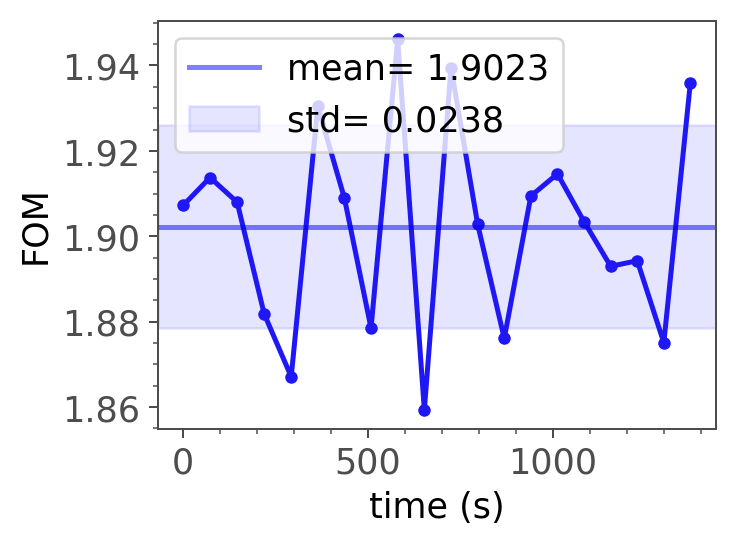

In [156]:
fom_mean = np.mean(foms[:,1])
fom_std = np.std(foms[:,1])

plt.figure(figsize=(4,3))
plt.plot(foms[:,0]-foms[0,0], foms[:,1])
plt.axhspan(fom_mean-fom_std, fom_mean+fom_std, alpha=0.1, color='blue', label=f'std= {fom_std:.4f}')
plt.axhline(fom_mean, alpha=0.5, color='blue', label=f'mean= {fom_mean:.4f}')


plt.ylabel("FOM")
plt.xlabel("time (s)")
plt.legend()
plt.show()


In [129]:
np.mean(foms[:,1]), np.std(foms[:,1])

(0.9464527585971627, 0.011418977900333992)

## Save the results

Currently need to hiz "stop" in optimalcontrol gui manually

In [93]:
try:
    save_optimization_result(folder_path)
except:
    logger.exception("")

In [ ]:
try:
    optimizer_obj = optimizationlogic.optimization_obj
    optimizer_obj.get_optimization_algorithm()
except:
    logger.exception("")

In [ ]:
optimizer_obj.__dict__

In [ ]:
pulses_list, time_grids_list, parameters_list = optimizer_obj.opt_alg_obj.get_best_controls()

t_amplitude = time_grids_list[0]
amplitude = pulses_list[0]
t_phase = time_grids_list[1]
phase = pulses_list[1]

In [ ]:
best_dict = optimizer_obj.opt_alg_obj.get_best_controls()

pulses_list = best_dict['pulses']
time_grids_list = best_dict['timegrids']
parameters_list = best_dict['parameters']

pulses_list

In [ ]:
optimizer_obj.opt_alg_obj.get_best_controls().keys()

In [749]:
pulse = get_pulse_from_logic(get_best=True)

optimizer_obj = optimizationlogic.optimization_obj
best_dict = optimizer_obj.opt_alg_obj.get_best_controls()
pulses, timegrids, parameters = best_dict['pulses'], best_dict['timegrids'], best_dict['parameters']
  

data_ampl = np.column_stack((timegrids[0], pulses[0]))
data_phase = np.column_stack((timegrids[0], pulses[1]))

best_dict['pulses']

[array([ 0.14656046,  0.15218134,  0.15775545,  0.16326872,  0.16870821,
        0.17406169,  0.17931722,  0.18446285,  0.18948629,  0.19437488,
        0.19911551,  0.20369473,  0.2080989 ,  0.2123144 ,  0.21632778,
        0.22012598,  0.2236964 ,  0.22702713,  0.23010692,  0.23292538,
        0.23547291,  0.23774086,  0.23972147,  0.24140794,  0.24279446,
        0.24387617,  0.24464925,  0.24511084,  0.24525909,  0.24509315,
        0.24461315,  0.24382018,  0.24271627,  0.24130441,  0.23958846,
        0.23757316,  0.23526409,  0.23266763,  0.22979091,  0.22664177,
        0.22322875,  0.21956097,  0.21564814,  0.21150049,  0.2071287 ,
        0.20254387,  0.19775743,  0.19278112,  0.18762691,  0.18230695,
        0.17683349,  0.17121886,  0.1654754 ,  0.15961538,  0.15365098,
        0.14759422,  0.14145691,  0.13525061,  0.12898657,  0.12267571,
        0.11632855,  0.1099552 ,  0.10356531,  0.09716804,  0.09077203,
        0.08438539,  0.07801567,  0.07166984,  0.06535428,  0.0

In [761]:
optimizer_obj.opt_alg_obj._get_final_results()

{'Figure of merit': 0.5351242162190543, 'Std': 0.0, 'total number of function evaluations': 2150, 'dcrab_freq_list': [array([[ 1.26258366,  5.81212271,  9.06792906],
       [ 0.43571273,  7.47266592, 10.51891407]]), array([[ 3.07031968,  7.45406655, 11.11048191],
       [ 0.90360062,  7.04155686,  9.76554149]]), array([[3.7532004 , 4.18917789, 8.00876221],
       [1.38549865, 6.71189548, 9.25646082]]), array([[2.17345659, 6.35884163, 8.92658767],
       [0.04530831, 6.91320574, 8.20458014]]), array([[0.60769751, 6.32291478, 8.75718807],
       [1.32483614, 5.56960255, 9.68929558]]), array([[3.71604241, 7.86638063, 8.75802141],
       [3.85689196, 6.59565936, 8.95446073]]), array([[0.92144038, 5.22448392, 9.61629154],
       [3.75665776, 4.72278585, 8.77776836]]), array([[ 0.25502529,  4.4984165 ,  9.66045407],
       [ 0.59546606,  7.54378213, 10.36042675]]), array([[0.18758619, 4.56695948, 9.00791375],
       [1.31743515, 6.97953289, 8.769438  ]]), array([[ 2.35923948,  7.40088684,  9

## manually extract best pulse from result log

In [ ]:
path = r"C:\Software\qudi_data\optimal_control_assets\20220724_1\20220723_202625_test_dCRAB_Noisy_2_control_fields"
file = r"20220723_202625_best_controls"
pulse = TimeDependentSimulation.load_pulse(path, file, extension='npz')

#path = r"C:\Software\qudi_data\optimal_control_assets\20220724_1"
#file = r"on_nv=2_"
#pulse = load_pulse(path, file, extension='txt')

pulse

In [ ]:
import matplotlib.pyplot as plt
    
t_amplitude = pulse['timegrid_ampl']
amplitude = pulse['data_ampl']
t_phase = pulse['timegrid_phase']
phase = pulse['data_phase']

try:
    plt.plot(t_amplitude*1e9, amplitude, label="Ampl (I)")
    plt.plot(t_phase*1e9, phase, label="Phase (Q)")
    plt.xlabel("time (ns)")
    plt.legend()
    plt.show()
except:
    logger.exception("")

In [ ]:
path = folder_path
name = "opt_pulse_"

data_ampl = np.column_stack((t_amplitude, amplitude))
data_phase = np.column_stack((t_phase, phase))

save_pulse(path, data_ampl, data_phase, name=name)


## Simulation only

In [33]:
script_params['readout_noise'] = 0#0.01*np.sqrt(2)

script_params['fom_func_volt_2_rabi'] = lambda y: y/ampl_rect*(1e-6/t_rabi_rect)

fom_func = setup_fom_simulation_sigz(f_res)
fom_func = add_penalty_freq_bandstop(fom_func, f_res, f_block, fac_penalty=10, n_f_sim=25, 
                                     symm_block=True, first_fom_req_pulse=True)

script_params['fom_function'] = fom_func
# debug
#fom_func = script_params['fom_function']
#fom_func(pulse, func_volt_2_rabi=script_params['fom_func_volt_2_rabi'])

script_params['readout_noise']

0

In [35]:
f_res = script_params['pulsed_generation_params']['microwave_frequency']
fom_func = setup_fom_simulation_sigz(f_res)
script_params['fom_func_volt_2_rabi'] = lambda y: y/ampl_rect*(1e-6/t_rabi_rect)




######################################################################################################
# Parameters and Settings
######################################################################################################

# runtime of each experiment
runtime = script_params['runtime_per_epoch']
length_oc = script_params['length_oc'] 

# parameter to stop the experiment if its set to False in the console
pulsedmasterlogic.globalrun = True
uglobals.abort.clear()
logger.info("Starting new closed-loop quocs optimization")


# array to save the fom evolution
fom_all = []

# This section is devoted to the initialization in the pulsed logic and optimization logic of the main
# settings and parameters to be usde in the creation ofthe pulse sequence and the optimization
# Iteration, controls and figure of merit to compare with QuOCS
# Just an example for debug
args_dict = {"is_noisy": script_params['is_noisy']}
qubit = OneQubit2Fields(args_dict)

######################################################################################################
# Measurement
######################################################################################################
optimalcontrol.start_optimization()

# crucial, maybe it can be much shorter
time.sleep(1)

# Just a time to check for latent time
last_time_fom = time.time()
# repeat the whole process until its manually stopped or QuOCS finsihed the optimization
# Wait few seconds before starting to get and return data
while not optimizationlogic.handle_exit_obj.is_user_running:
    time.sleep(0.1)
    if (time.time() - last_time_fom) > 30 or uglobals.abort.is_set():
        logger.warning("Timeout or abort while initializing quocs.")
        uglobals.abort.set()
        break

# iteration number
it_val = 0

# when did the optimization start?
opt_start_time = time.time()
try:
    # print("Check before the loop starts: {0}".format(optimizationlogic.handle_exit_obj.is_user_running))
    while optimizationlogic.handle_exit_obj.is_user_running == True and not uglobals.abort.is_set():
        time_stamp=time.time()
        # wait until QuOCS optimizes the controls
        # print("Wait until the controls logic gives the controls")
        while not controlslogic.are_pulses_calculated:
            time.sleep(0.1)
            # If the waiting time exceed 10 seconds left stop the optimization
            if time.time() - last_time_fom > 20:
                logger.error("Too much time... Exit!")
                optimizationlogic.handle_exit_obj.is_user_running = False
                break

 
        #######################################################################################################
        # Get the Controls
        #######################################################################################################
        # Change the status of control calculations to avoid to evaluate the fom twice with the same controls
        controlslogic.are_pulses_calculated = False
        # Get the controls from the controls logic
        pulse = get_pulse_from_logic(get_best=False)
        t_amplitude = pulse.get_timegrid(unit='s')
        t_phase = pulse.get_timegrid(unit='s')
        amplitude = pulse.get_data_ampl(unit='V')
        phase = pulse.get_data_phase(unit='V')
        #######################################################################################################
        # Perform the measurement
        #######################################################################################################

        # save the pulses as .txt files (predefined methods doesn't allow us to upload a numpy array as 
        # parameter)
        data_ampl = np.column_stack((t_amplitude, amplitude))
        data_phase = np.column_stack((t_phase, phase))
        save_pulse(folder_path, data_ampl, data_phase, name=filename)

        time.sleep(0.5)
        
       
        measurement_start_time = time.time()

        # option to stop the measurement
        if pulsedmasterlogic.globalrun == False or uglobals.abort.is_set():
            print('Stopping the measurement!')
            break


        #######################################################################################################
        # Analysis
        ######################################################################################################

        fom_func = script_params['fom_function']
        if script_params['fom_func_volt_2_rabi'] is None:
            fom = fom_func()
        else:
            pulse = ArbPulse.load_pulse(folder_path, filename, unit_t='s', unit_data='V')
            fom = fom_func(pulse, func_volt_2_rabi=script_params['fom_func_volt_2_rabi'])
        
        fom += np.random.normal(0, script_params['readout_noise'])
        fom = abs(fom)
                                
        fom_all.append(fom)

        # Update the figure of merit and the standard deviation to the fom logic
        fomlogic.update_fom(fom, script_params['readout_noise'], status_code=0)   # todo: define above
        #fomlogic.update_fom(fom, std, status_code=0)

        # update the last time the fom is calculated
        last_time_fom = time.time()

    # when did the optimization stop?
    opt_end_time = time.time()

    print('It took QuOCS ' + str(opt_end_time-opt_start_time) + ' s to optimize the pulse!')
except:
    logger.exception("")
finally:
    # give a very high fom to the optimization algorithm
    # and status code -1, to interrupt the optimization smoothly
    uglobals.abort.set()
    optimizationlogic.handle_exit_obj.is_user_running = False
    logger.info('Stopping the optimization!')
    fomlogic.update_fom(10**10, status_code=-1)

print("Optimization finished")